In [1]:
# importing packages. See https://github.com/BasisResearch/collab-creatures for repo setup
import logging
import os
import time
import warnings

import torch
import pyro
import pyro.distributions as dist

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

warnings.simplefilter(action="ignore", category=FutureWarning)

from collab.utils import find_repo_root

root = find_repo_root()
from collab.foraging import random_hungry_followers as rhf
from collab.foraging.toolkit import (
    add_velocities_to_data_object,
    construct_visibility,
    filter_by_visibility,
    generate_grid,
    generate_velocity_scores,
)


import plotly.express as px
import plotly.graph_objects as go
import pyro
import pyro.distributions as dist
import pyro.optim as optim
import torch
from pyro.infer import SVI, Predictive, Trace_ELBO
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean


from collab.foraging import toolkit as ft

logging.basicConfig(format="%(message)s", level=logging.INFO)

# users can ignore smoke_test -- it's for automatic testing on GitHub, to make sure the notebook runs on future updates to the repository
smoke_test = "CI" in os.environ
num_frames = 5 if smoke_test else 50
num_svi_iters = 10 if smoke_test else 1000
num_samples = 10 if smoke_test else 1000

notebook_starts = time.time()


In [2]:
# data cleanup function

def prep_data_for_inference(sim_derived, features = [
            "proximity_standardized",
            "trace_standardized",
            "visibility",
            "velocity_score_standardized",
            "how_far",
            "how_far_squared_scaled",
        ]):
    df = sim_derived.derivedDF[features]

    df.dropna(inplace=True)

    for column in df.columns:
        df[column] = ft.normalize(df[column])

    data = torch.tensor(df.values, dtype=torch.float32)

    proximity, trace, visibility, velocity, how_far_score = (
        data[:, 0],
        data[:, 1],
        data[:, 2],
        data[:, 3],
        data[:, 4],
    )

    print(
        str(len(proximity))
        + " data points prepared for inference, dropped "
        + str(len(sim_derived.derivedDF) - len(proximity))
        + " rows with missing values."
    )
    return proximity, trace, visibility, velocity, how_far_score

In [3]:
# generate random foragers simulation

random_foragers_sim = rhf.RandomForagers(
    grid_size=40,
    probabilities=[1, 2, 3, 2, 1, 2, 3, 2, 1],
    num_foragers=3,
    num_frames=num_frames,
    num_rewards=15,
    grab_range=3,
)

# simulate
random_foragers_sim()

/home/rafal/s78projects/collaborative-intelligence/collab/foraging/random_hungry_followers/random_foragers.py:163: UserWarning: Warning: forager movements truncated to grid size. Try running again, or increase grid size.
  warnings.warn(


## Copying without further filters or averaging

Consider agent 1. In the  simplest mode, at each frame, for each other agent $i$ in 1's visibility range, we calculate $i$'s velocity on the two axes in the last step, shift them to start at the position currently occupied by $1$ and assign scores to points with exponential decay function of distance from these "ideal" locations, summing them up accross all $i$'s.  

In [4]:
# derive predictors
random_foragers_derived = ft.derive_predictors(
    random_foragers_sim,  dropna=False,
    generate_velocity_indicator=True,
    visibility_range=20,   # agents will only copy from visible agents
    velocity_time_decay=1, # agents will only remember the last step
    velocity_spatial_decay=.15  # this captures how fast location attractiveness drops off
    # with distance
)

2024-05-28 12:38:55,988 - traces done
2024-05-28 12:38:56,258 - visibility done
2024-05-28 12:38:56,516 - proximity done
2024-05-28 12:38:56,637 - how_far done
2024-05-28 12:38:56,718 - derivedDF done
2024-05-28 12:38:56,718 - starting to generate velocity
2024-05-28 12:38:57,209 - velocity done


In [5]:
# rows are these are sampled points in space-time
print(random_foragers_derived.derivedDF.columns)

random_foragers_derived.derivedDF.head()

Index(['x', 'y', 'trace', 'time', 'trace_standardized', 'distance',
       'distance_x', 'distance_y', 'visibility', 'forager', 'proximity',
       'proximity_standardized', 'how_far_squared', 'how_far',
       'how_far_squared_scaled', 'velocity_score',
       'velocity_score_standardized'],
      dtype='object')


x   y     trace  time  trace_standardized   distance  distance_x  \
0  14   7  0.102066     1           -0.386360  12.806248         8.0   
1  14   7  0.102066     1           -0.386360  14.422205         8.0   
2  14   7  0.102066     1           -0.386360  15.297059         3.0   
3   9  35  0.076149     1           -0.473831  15.264338         8.0   
4   5   9  0.020620     1           -0.661247  18.788294        17.0   

   distance_y  visibility  forager     proximity  proximity_standardized  \
0        10.0    0.535412        1  1.040862e-04               -0.413631   
1        12.0    0.424201        2  4.003256e-04               -0.406614   
2        15.0    0.361026        3  4.431581e-04               -0.358038   
3        13.0    0.363422        3  1.807433e-07               -0.359116   
4         8.0    0.095024        1  3.159398e-06               -0.413914   

   how_far_squared    how_far  how_far_squared_scaled  velocity_score  \
0            290.0  17.029386                0.748264        0.292939   
1            185.0  13.601471                0.839410        0.229883   
2            298.0  17.262677                0.741319        0.201612   
3            185.0  13.601471                0.839410        0.202604   
4            521.0  22.825424                0.547743        0.119421   

   velocity_score_standardized  
0                     0.005092  
1                    -0.217475  
2                    -0.303838  
3                    -0.300482  
4                    -0.581859

In [6]:
# first take a look at visibility for agent 1

ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_visibility=1,
    plot_traces=False,
    plot_velocity=0,
)

In [7]:
# now plot velocity for agent 1

ft.animate_foragers(
    random_foragers_derived,
    plot_rewards=True,
    width=600,
    height=600,
    point_size=10,
    plot_visibility=0,
    plot_traces=False,
    plot_velocity=1,
    velocity_multiplier= 7
)

In [8]:
proximity, trace, visibility, velocity, how_far, how_far_scaled = prep_data_for_inference(
    random_foragers_derived
)

#ft.visualise_forager_predictors(trace, proximity, how_far_score, vel = velocity,)

121944 data points prepared for inference, dropped 2015 rows with missing values.


ValueError: not enough values to unpack (expected 6, got 5)

In [9]:
random_foragers_derived.derivedDF.head()

x   y     trace  time  trace_standardized   distance  distance_x  \
0  14   7  0.016106     1           -0.850363  14.866069        10.0   
1  14   7  0.016106     1           -0.850363  16.278821         3.0   
2  14   7  0.016106     1           -0.850363  17.000000         8.0   
3   9  35  0.140160     1           -0.240836  14.422205         8.0   
4   9  35  0.140160     1           -0.240836  18.384776        13.0   

   distance_y  visibility  forager  proximity  proximity_standardized  \
0        11.0    0.392380        1   0.000017               -0.418628   
1        16.0    0.288118        2   0.000053               -0.415971   
2        15.0    0.233445        3   0.000059               -0.424987   
3        12.0    0.424201        2   0.000001               -0.416113   
4        13.0    0.126519        3   0.000073               -0.424943   

   how_far_squared  how_far_squared_scaled  velocity_score  \
0            193.0                0.832465        0.215076   
1            226.0                0.803819        0.174004   
2            245.0                0.787326        0.156163   
3            205.0                0.822049        0.229883   
4            340.0                0.704861        0.126873   

   velocity_score_standardized  
0                    -0.254570  
1                    -0.393193  
2                    -0.468273  
3                    -0.204595  
4                    -0.567920

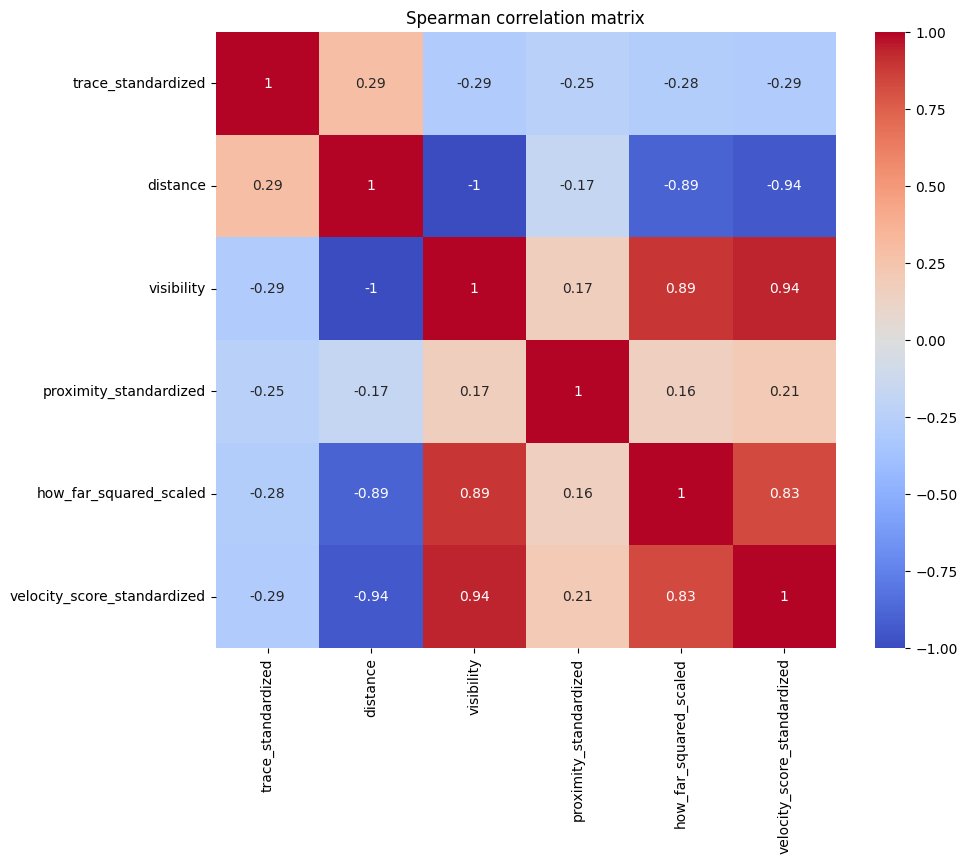

In [10]:

selected_columns =  ['trace_standardized', 'distance', 'visibility', 'proximity_standardized', 'how_far_squared_scaled', 'velocity_score_standardized']
correlation_matrix = random_foragers_derived.derivedDF[selected_columns].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Spearman correlation matrix')
plt.show()


In [11]:
# idea (investigate posterior variance due to colinearity, though)

def model_no_velocity(proximity, trace, visibility, how_far_score):
    p = pyro.sample("p", dist.Normal(0, 0.2))
    t = pyro.sample("t", dist.Normal(0, 0.2))
    v = pyro.sample("v", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    ps = pyro.sample("ps", dist.Exponential(7))
    ts = pyro.sample("ts", dist.Exponential(7))
    vs = pyro.sample("vs", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic(
        "sigma", bs + ps * proximity + ts * trace + vs * visibility
    )
    mean = pyro.deterministic("mean", b + p * proximity + t * trace + v * visibility)

    with pyro.plate("data", len(how_far_score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=how_far_score)

In [12]:
def model_with_velocity(proximity, trace, visibility, velocity, how_far_score):
    p = pyro.sample("p", dist.Normal(0, 0.2))
    t = pyro.sample("t", dist.Normal(0, 0.2))
    vis = pyro.sample("vis", dist.Normal(0, 0.2))
    vel = pyro.sample("vel", dist.Normal(0, 0.2))
    b = pyro.sample("b", dist.Normal(0.5, 0.3))

    ps = pyro.sample("ps", dist.Exponential(7))
    ts = pyro.sample("ts", dist.Exponential(7))
    vis_s = pyro.sample("vis_s", dist.Exponential(7))
    vel_s = pyro.sample("vel_s", dist.Exponential(7))
    bs = pyro.sample("bs", dist.Exponential(7))

    sigma = pyro.deterministic(
        "sigma", bs + ps * proximity + ts * trace + vis_s * visibility + vel_s * velocity
    )

    mean = pyro.deterministic("mean", b + p * proximity + t * trace + vis * visibility + vel * velocity)

    with pyro.plate("data", len(how_far_score)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=how_far_score)

In [13]:
def get_samples(model, num_svi_iters, num_samples, **kwargs):
    
    guide = AutoMultivariateNormal(model, init_loc_fn=init_to_mean)
    svi = SVI(model, guide, optim.Adam({"lr": 0.03}), loss=Trace_ELBO())

    iterations = []
    losses = []

    logging.info(f"Starting SVI inference with {num_svi_iters} iterations.")
    start_time = time.time()
    pyro.clear_param_store()
    for i in range(num_svi_iters):
        elbo = svi.step(**kwargs)
        iterations.append(i)
        losses.append(elbo)
        if i % 200 == 0:
            logging.info("Elbo loss: {}".format(elbo))
    end_time = time.time()
    elapsed_time = end_time - start_time
    logging.info("SVI inference completed in %.2f seconds.", elapsed_time)




In [15]:
get_samples(model_no_velocity, num_svi_iters=10 , num_samples = 10,
             proximity=proximity, trace=trace, visibility=visibility,
               how_far_score=how_far_score)

get_samples(model_with_velocity, num_svi_iters=10 , num_samples = 10,
                proximity=proximity, trace=trace, visibility=visibility,
                velocity=velocity,
                how_far_score=how_far_score)

2024-05-28 12:33:40,761 - Starting SVI inference with 10 iterations.
2024-05-28 12:33:40,794 - Elbo loss: -2289.841191112995
2024-05-28 12:33:40,940 - SVI inference completed in 0.18 seconds.
2024-05-28 12:33:40,941 - Starting SVI inference with 10 iterations.
2024-05-28 12:33:40,961 - Elbo loss: 9125.832410097122
2024-05-28 12:33:41,094 - SVI inference completed in 0.15 seconds.
